
# Baltimore Vital Signs

The <a href='http://bniajfi.org/indicators/all'>Baltimore Neighborhoods Indicators Alliance - Jacob France Institute (BNIA)</a> at the University of Baltimore has made it their mission to provide a clean, concise set of indicators that illustrate the health and wealth of the city. There are 152 socio-economic indicators in the Vital Signs dataset, and some are reported for multiple years which results in 295 total variables for each of the 56 Baltimore neighborhoods captured.  The indicators are dug up from a number of sources, including the U.S. Census Bureau and its American Community Survey, the FBI and Baltimore Police Department, Baltimore departments of city housing, health, and education.

In [1]:
import glob
import numpy as np
import pandas as pd
import plotly.plotly as py
import plotly.graph_objs as pgo

In [2]:
# Load and combine the datasets.
path = 'raw_data/csv'

allFiles = glob.glob(path + '/*.csv')
df = pd.DataFrame()

for i, filename in enumerate(allFiles):
    df_file = pd.read_csv(filename)
    if i == 0:
        df = df_file
    else:
        df = pd.merge(df, df_file)

In [3]:
df.index = df['CSA2010']
df.drop('CSA2010', inplace=True)
print len(df.columns)
del df['CSA2010']
print len(df.columns)

296
295


In [4]:
cols = df.columns
df[cols] = (
    df[cols]
    # Replace things that aren't numbers and change any empty entries to nan
    # (to allow type conversion)
    .replace({r'[^0-9\.]': '', '': np.nan}, regex=True)
    # Change to float and convert from %s
    .astype(np.float64)
)

In [5]:
# One of the rows is an aggregate Baltimore City.
df.drop('Baltimore City', inplace=True)

# A Few Exploratory Plots

## Percentage of Population White in Each Neighborhood, Sorted

In [6]:
df_white_sorted = df['pwhite10'].sort(inplace=False)

In [7]:
# Create a horizontal bar chart with plotly.
data = pgo.Data([
    pgo.Bar(
            y=df_white_sorted.index,
            x=df_white_sorted,
            orientation='h'
    )
])

In [8]:
layout = pgo.Layout(
    title='% White',
    margin=pgo.Margin(l=300)  # add left margin for y-labels are long
)

In [9]:
fig = pgo.Figure(data=data, layout=layout)

In [10]:
# Address InsecurePlatformWarning from running Python 2.7.6
import urllib3.contrib.pyopenssl
urllib3.contrib.pyopenssl.inject_into_urllib3()

In [11]:
py.iplot(fig, filename='baltimore-barh',
         width=700, height=1000)  # adjust notebook display width and height

## Percentage of Households in Poverty and with Children, Sorted

In [12]:
df_chpov_sorted = df['hhchpov12'].sort(inplace=False)

In [13]:
data1 = pgo.Data([
    pgo.Bar(
            y=df_chpov_sorted.index,
            x=df_chpov_sorted,
            orientation='h'
    )
])

In [14]:
# Specify some layout attributes.
layout1 = pgo.Layout(
    title='% HH Children in Poverty',
    margin=pgo.Margin(l=300)  # add left margin for y-labels are long
)

In [15]:
fig1 = pgo.Figure(data=data1, layout=layout1)

In [16]:
py.iplot(fig1, filename='baltimore-hh-pov', width=700, height=1000)

## Percent Households in Poverty with Children vs. Percent Population White <br> Bubbles Sized by Number of School-aged Children <br> (Matplotlib)

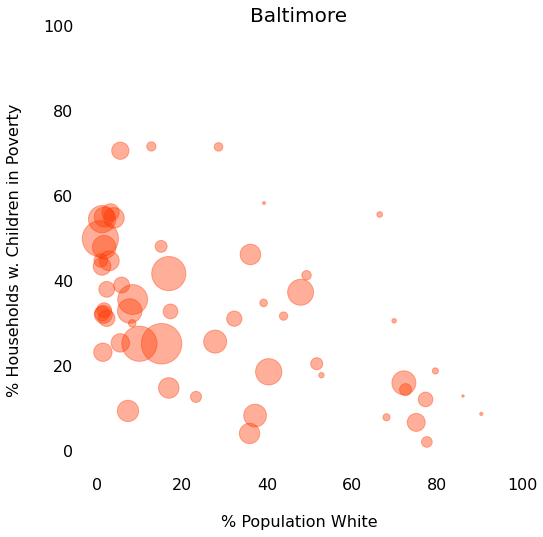

In [3]:
# pandas only
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[8,8])
ax1 = plt.subplot(1,1,1)

df.drop('Baltimore City', inplace=True)

x = df['pwhite10']#.apply(lambda x: x[:-1]).astype(float)
y = df['hhchpov12']#.apply(lambda x: x[:-1]).astype(float)
schoolage_pop = df['tpop10'] * df['age18_10'] / 100 #.apply(lambda x: x[:-1]).astype(float)
s = (schoolage_pop/50)**2 

plt.scatter(x,y,
            color=red_orange,
            marker='.',
            s=s,
            alpha=.4)

xlabel('\n% Population White',fontsize=16)
ylabel('% Households w. Children in Poverty\n',fontsize=16)
xlim([-5,100])
ylim([-5,100])
title('Baltimore', fontsize=20)

# turn off square border around plot
ax1.spines["top"].set_visible(False)  
ax1.spines["bottom"].set_visible(False)  
ax1.spines["right"].set_visible(False)  
ax1.spines["left"].set_visible(False)

# turn off ticks
ax1.tick_params(axis="both", which="both", bottom="off", top="off",
               labelbottom="on", left="off", right="off", labelleft="on",labelsize=16)

plt.show()


## Percent Households in Poverty with Children vs. Percent Population White <br> Bubbles Sized by Number of School-aged Children <br> (Plotly for interactivity)

In [6]:
# same plot, interactive from plotly

#df.drop('Baltimore City', inplace=True)

import plotly.plotly as py

x = df['pwhite10']#.apply(lambda x: x[:-1]).astype(float)
y = df['hhchpov12']#.apply(lambda x: x[:-1]).astype(float)
schoolage_pop = df['tpop10'] * df['age18_10']/100#.apply(lambda x: x[:-1]).astype(float)


trace1 = Scatter(x=x,
                 y=y,
                 text = np.array(x.index),
                 mode = 'markers',
                 marker = Marker(size = schoolage_pop,
                                 sizemode = 'area',
                                 sizeref = schoolage_pop.max()/1000,
                                 opacity = 0.5,
                                 color = 'blue')
)

layout = Layout(
    title = 'Baltimore: Too Many Non-White Kids in Poverty',
    xaxis = XAxis(range = [-5,100],
                  title = '% Population White (2010)',
                  showgrid = False,
                  showline = False,
                  zeroline = False,
                  autotick = False,
                  dtick = 20),
    yaxis = YAxis(range = [-5,100],
                  title = '% Households w. Children in Poverty (2012)',
                  showgrid = False,
                  showline = False,
                  zeroline = False,
                  autotick = False,
                  dtick = 20),
    autosize = False,
    width=500,
    height=500,
    font = Font(size=14),
    hovermode = 'closest'   
)

data = Data([trace1])
fig = Figure(data=data, layout=layout)
py.iplot(fig, filename='Baltimore Percent Child Poverty Percent White')

## Percent of Households in Poverty vs. Ethnicity's Percent of Population

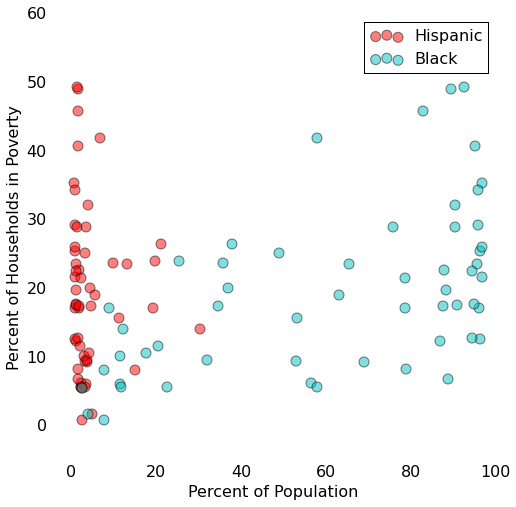

In [32]:

size = 100
alpha = 0.5
fontsize = 16

fig = plt.figure(figsize=[8,8])
ax1 = plt.subplot(1,1,1)

scatter(df['phisp10'],df['hhpov12'],c='r',alpha=alpha,s=size)
scatter(df['paa10'],df['hhpov12'],c='c',alpha=alpha,s=size)

legend(['Hispanic','Black'],fontsize=fontsize)
xlabel('Percent of Population',fontsize=fontsize)
ylabel('Percent of Households in Poverty',fontsize=fontsize)

# turn off square border around plot
ax1.spines["top"].set_visible(False)  
ax1.spines["bottom"].set_visible(False)  
ax1.spines["right"].set_visible(False)  
ax1.spines["left"].set_visible(False)

# turn off ticks
ax1.tick_params(axis="both", which="both", bottom="off", top="off",
               labelbottom="on", left="off", right="off", labelleft="on",labelsize=16)

xlim([-5,100])
ylim([-5,60])

plt.show()

Hispanic communities are smaller fractions of neighborhood populations.

# Principal Component Analysis

<a href='http://www.thetrainingset.com/articles/A-City-Divided-In-N-Dimensions'>Read this post at The Training Set for purpose of this analysis.</a>

In [35]:
from sklearn.decomposition import PCA as PCA
from sklearn.preprocessing import StandardScaler

Plot sorted percent of variation in the data by the number of dimensions used in the Principal Component Analysis.  Total variance explained by the first two principal dimensions is approximately 48%.

<Container object of 55 artists>

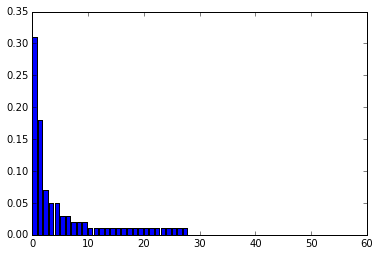

In [36]:
X = np.array(df)
scaler = StandardScaler()#.fit(X)
X_scaled = scaler.fit_transform(X)

pca = PCA()
pca.fit(X_scaled)
#print(pca.explained_variance_)  
#print pd.Series(pca.explained_variance_ratio_).apply(lambda x: round(x,2))
bar(range(0,len(pca.explained_variance_ratio_)),pd.Series(pca.explained_variance_ratio_).apply(lambda x: round(x,2)))

In [37]:
'''
cov_mat = np.cov(X_scaled.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)
print len(eig_vals)
'''

"\ncov_mat = np.cov(X_scaled.T)\neig_vals, eig_vecs = np.linalg.eig(cov_mat)\nprint('Eigenvectors \n%s' %eig_vecs)\nprint('\nEigenvalues \n%s' %eig_vals)\nprint len(eig_vals)\n"

Essentially the same information as previous plot, but cumulative. <br>
Two points of interest.  First two dimensions make up about 48% of variance in data.  To explain approximately 90% of variance, would need about 20 dimensions.

(0, 1)

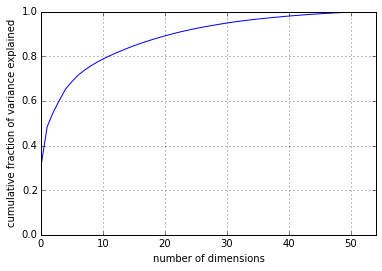

In [39]:
pd.Series(pca.explained_variance_ratio_).cumsum().plot()
xlabel('number of dimensions')
ylabel('cumulative fraction of variance explained')
ylim([0,1])
#sum(pca.explained_variance_ratio_[:5])

In [7]:
pca.n_components = 2
X_reduced = pca.fit_transform(X_scaled)
print 'Shape: ', X_reduced.shape
print 'Explained Variance Ratio = ', round(sum(pca.explained_variance_ratio_[:pca.n_components]),2)

Shape:  (55, 2)
Explained Variance Ratio =  0.48


Result of PCA (2 dimesnions, x and y) plotted below. 

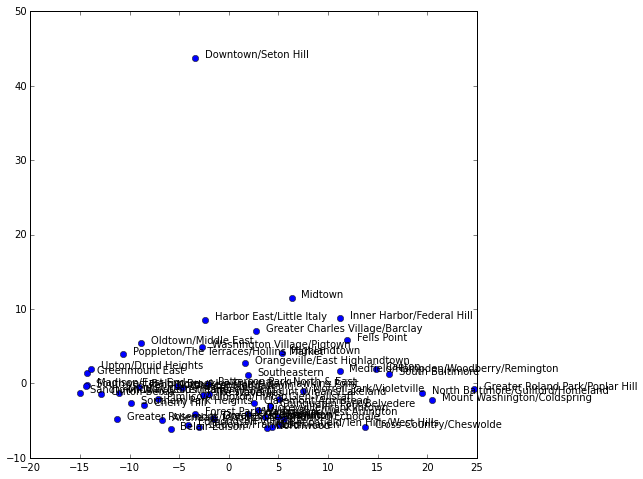

In [8]:
df_X_reduced = pd.DataFrame(X_reduced, index=df.index)

fig = plt.figure(figsize=[8,8])
ax = plt.subplot(1,1,1)
plot(df_X_reduced[0], df_X_reduced[1], marker='o', linestyle='', alpha=1.0)
#xlim([-7,7])
#ylim([-10,15])
ii=0
for i,j in zip(df_X_reduced[0],df_X_reduced[1]):
    
    ax.annotate('%s' %df_X_reduced.ix[ii].name, xy=(i,j), xytext=(10,0), textcoords='offset points')
    ii = ii+1

PCA Results (2 dimensions) using Plot.ly for interactivity.  Bubbles sized using total population of each neighborhood.

In [9]:
x = df_X_reduced[0]#.apply(lambda x: x[:-1]).astype(float)
y = df_X_reduced[1]#.apply(lambda x: x[:-1]).astype(float)
xscale = 22
yscale = 10
#schoolage_pop = df['tpop10'] * df['age18_10']/100#.apply(lambda x: x[:-1]).astype(float)


trace1 = Scatter(x=x,
                 y=y,
                 text = df.index,
                 mode = 'markers',
                 marker = Marker(size = df['tpop10']/500,
                                 sizemode = 'diameter',
                                 #sizeref = schoolage_pop.max()/1000,
                                 opacity = 0.5,
                                 color = 'blue')
)

layout = Layout(
    title = 'Baltimore Vital Signs PCA',
    xaxis = XAxis(range = [-xscale,xscale],
                  title = '',
                  showgrid = False,
                  showline = False,
                  zeroline = False,
                  autotick = False,
                  showticklabels=False),
    yaxis = YAxis(range = [-1*yscale,yscale],
                  title = '',
                  showgrid = False,
                  showline = False,
                  zeroline = False,
                  autotick = False,
                  showticklabels=False),
    autosize = False,
    width=500,
    height=500,
    font = Font(size=14),
    hovermode = 'closest'   
)

data = Data([trace1])
fig = Figure(data=data, layout=layout)
py.iplot(fig, filename='Baltimore PCA')

# K-means Clustering

In [40]:
from sklearn.cluster import KMeans

#reduced_data = PCA(n_components=2).fit_transform(data)
def cluster(n_clusters):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X_reduced)
    Z = kmeans.predict(X_reduced)
    return kmeans, Z

Since the number of clusters assigned is a manual input, we can get a feel for an appropriate number of clusters by plotting the inertia as a function of number of clusters.

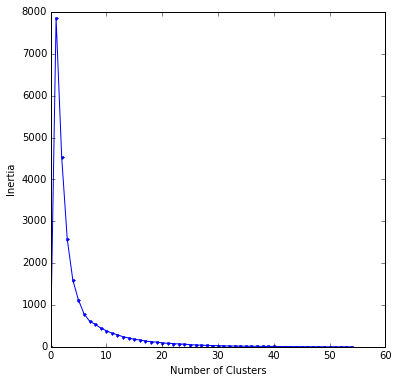

In [42]:
max_clusters = len(df)

inertias = zeros(max_clusters)

for i in range(1,max_clusters):
        kmeans, Z = cluster(i)
        inertias[i] = kmeans.inertia_

fig = plt.figure(figsize=[6,6])
ax1 = plt.subplot(1,1,1)
plot(inertias,marker='.')
xlabel('Number of Clusters')
ylabel('Inertia')
#xlim([1,14])
plt.show()

Below is what the k-means clustering looks like for 7 clusters.

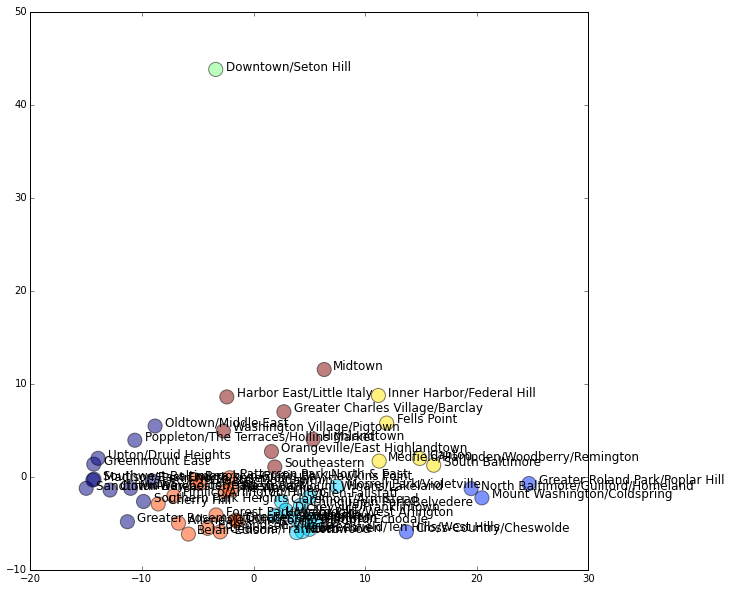

In [11]:
n_clusters = 7
model, Z = cluster(n_clusters)

fig = plt.figure(figsize=[10,10])
ax = plt.subplot(1,1,1)
plt.scatter(df_X_reduced[0], df_X_reduced[1], c=Z, marker='o', alpha=.5, s=200)
#xlim([-7,7])
#ylim([-10,15])
ii=0
for i,j in zip(df_X_reduced[0],df_X_reduced[1]):
    ax.annotate('%s' %df_X_reduced.ix[ii].name, xy=(i,j), xytext=(10,0), textcoords='offset points', fontsize=12, alpha=1.0)
    ii = ii+1
plt.show()

Again, using Plot.ly for interactivity, bubbles sized by total population in neighborhood.

In [26]:
n_clusters = 7
model, Z = cluster(n_clusters)
x_c = model.cluster_centers_[:,0]
y_c = model.cluster_centers_[:,1]

h=1

x = df_X_reduced[0]#.apply(lambda x: x[:-1]).astype(float)
y = df_X_reduced[1]#.apply(lambda x: x[:-1]).astype(float)
xscale = 22
yscale = 10
#schoolage_pop = df['tpop10'] * df['age18_10']/100#.apply(lambda x: x[:-1]).astype(float)

# Plot the decision boundary. For that, we will asign a color to each
x_min, x_max = x.min() + 1, x.max() - 1
y_min, y_max = y.min() + 1, y.max() - 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Zc = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
# Put the result into a color plot
#Z = Z.reshape(xx.shape)
#plt.figure(1)
#plt.clf()


trace1 = Scatter(x=x,
                 y=y,
                 text = df.index,
                 name = '',
                 mode = 'markers',
                 marker = Marker(size = df['tpop10']/400,
                                 sizemode = 'diameter',
                                 #sizeref = schoolage_pop.max()/1000,
                                 opacity = 0.6,
                                 color = Z)
)

trace2 = Scatter(x=x_c,
                 y=y_c,
                 mode = 'markers',
                 text = '',
                 name='',
                 marker = Marker(symbol='x',
                                 size=15,
                                 color = [0,1,2,3,4,5,6])
)

layout = Layout(
    title = 'Baltimore Vital Signs PCA w/ K-Means Clustering <br> Number of Clusters: 7',
    xaxis = XAxis(range = [-xscale,xscale],
                  title = '',
                  showgrid = False,
                  showline = False,
                  zeroline = False,
                  autotick = False,
                  showticklabels=False),
    yaxis = YAxis(range = [-1*yscale,yscale],
                  title = '',
                  showgrid = False,
                  showline = False,
                  zeroline = False,
                  autotick = False,
                  showticklabels=False),
    autosize = False,
    width=600,
    height=600,
    font = Font(size=14),
    hovermode = 'closest',
    showlegend=False
)

data = Data([trace1,trace2])
fig = Figure(data=data, layout=layout)
py.iplot(fig, filename='Baltimore PCA, K-Means Cluster')
